# 7-11. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기
이전 스텝까지는 영문 텍스트의 감정분석을 진행해 보았습니다. 그렇다면 이번에는 한국어 텍스트의 감정분석을 진행해 보면 어떨까요? 오늘 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus입니다.

데이터 다운로드 없이 Cloud shell에서 해당 파일의 심볼릭 링크를 연결 해 주세요




### 평가기준
1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다. (3가지 이상의 모델이 성공적으로 시도됨)

2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다. (gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함)

3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다. (네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함)

In [1]:
!pip install --upgrade gensim==3.8.3

### 1) 데이터 준비와 확인

In [2]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터로더 구성


실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

 - 데이터의 중복 제거
 - NaN 결측치 제거
 - 한국어 토크나이저로 토큰화
 - 불용어(Stopwords) 제거
 - 사전word_to_index 구성
 - 텍스트 스트링을 사전 인덱스 스트링으로 변환
 - X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:

from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
# encode가 정상적으로 decode 되는지 확인

print(X_train[0])
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


#### 데이터셋에 PAD, BOS, UNK가 없다.

확인해 보면, 앞쪽에 있어야 할 PAD, BOS, UNK가 나타나지 않았음을 알 수 있다. 이들을 각각 index 0, 1, 2로 대응시켜 딕셔너리에 포함시킨다.

In [7]:
word_to_index

word_to_index["<PAD>"] = 0  # 패딩
word_to_index["<BOS>"] = 1  # 모든 문장의 시작
word_to_index["<UNK>"] = 2  # Unknown을 의미


index_to_word = {index:word for word, index in word_to_index.items()}

### 3) 모델구성을 위한 데이터 분석 및 가공


 - 데이터셋 내 문장 길이 분포
 
 
 - 적절한 최대 문장 길이 지정
     = 문장 최대 길이 maxlen의 값 설정도 전체 모델 성능에 영향을 미치게 된다. 이 길이도 적절한 값을 찾기 위해서는 전체 데이터셋의 분포를 확인해 보는 것이 좋다.


- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [8]:
# 데이터셋 내의 문장길이분포


print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [9]:
# 적절한 최대문장길이 지정

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


리뷰의 최대 길이 : 116
리뷰의 평균 길이 : 15.98170773419436


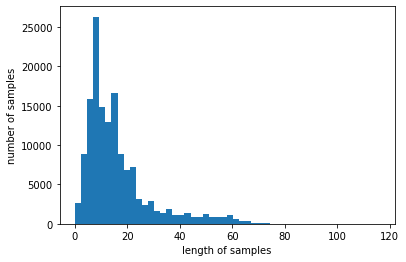

In [10]:

print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train)) / len(X_train))

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

##### 처음에 maxlen의 값을 높였을 때 전체 문장이 maxlen 설정값 이내에 포함되는 값이 클 수록 좋은 것이라고 생각했다.


##### 다만 문장길이가 너무 긴 이상치를 가진 데이터를 제거하고 학습하는 것이 더 효율적이라고 판단하여 maxlen을 int(평균 + 2*표준편차)로 지정하였다.

In [11]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                       value=word_to_index["<PAD>"],
                                       padding='post',
                                       maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                       value=word_to_index["<PAD>"],
                                       padding='post',
                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [12]:
X_train[0]

array([ 32,  74, 919,   4,   4,  39, 228,  20,  33, 748,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32)

In [13]:
# 훈련 데이터 앞쪽 50000개 까지 validation set으로 사용
X_val = X_train[:50000]
y_val = y_train[:50000]


# validation set을 제외한 나머지는 모두 훈련 데이터로 사용
partial_x_train = X_train[50000:]
partial_y_train = y_train[50000:]

print(partial_x_train.shape)
print(partial_y_train.shape)
print(X_val.shape)
print(y_val.shape)

(96182, 41)
(96182,)
(50000, 41)
(50000,)


### 4) 모델구성 및 validation set 구성

모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

#### 1-D Conv

In [14]:

vocab_size = 10000 # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 10  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
188/188 [==============================] - 10s 31ms/step - loss: 0.6274 - accuracy: 0.6296 - val_loss: 0.3688 - val_accuracy: 0.8397
Epoch 2/10
188/188 [==============================] - 2s 9ms/step - loss: 0.3403 - accuracy: 0.8552 - val_loss: 0.3479 - val_accuracy: 0.8477
Epoch 3/10
188/188 [==============================] - 2s 8ms/step - loss: 0.2964 - accuracy: 0.8777 - val_loss: 0.3465 - val_accuracy: 0.8499
Epoch 4/10
188/188 [==============================] - 2s 8ms/step - loss: 0.2633 - accuracy: 0.8947 - val_loss: 0.3564 - val_accuracy: 0.8482
Epoch 5/10
188/188 [==============================] - 2s 8ms/step - loss: 0.2295 - accuracy: 0.9122 - val_loss: 0.3712 - val_accuracy: 0.8438
Epoch 6/10
188/188 [==============================] - 2s 8ms/step - loss: 0.1952 - accuracy: 0.9276 - val_loss: 0.3964 - val_accuracy: 0.8424
Epoch 7/10
188/188 [==============================] - 2s 8ms/step - loss: 0.1636 - accuracy: 0.9424 - val_loss: 0.4305 - val_accuracy: 0.8384
Epoc

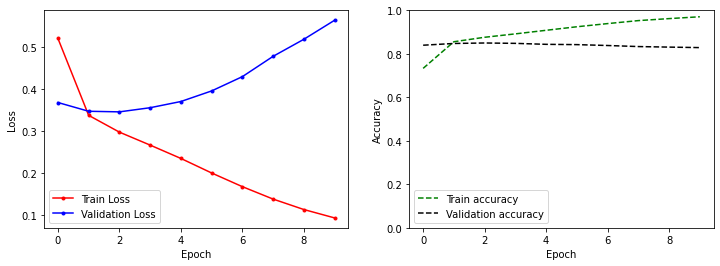

In [16]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], marker='.', c='red', label='Train Loss')
plt.plot(history.history['val_loss'], marker='.', c='blue', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g--', label='Train accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.show()

In [17]:
# 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.5806 - accuracy: 0.8240
[0.5806022882461548, 0.8240128755569458]


#### LSTM

In [18]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GRU

# Optimizer를 인수로 받는 train_model() 함수
def train_model(Optimizer, X_train, y_train, X_val, y_val):
    model = keras.Sequential()
    model.add(Embedding(input_dim=10000, output_dim=16))
    model.add(LSTM(units=128))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Optimizer,
                  metrics=['accuracy'])
    scores = model.fit(X_train, y_train, batch_size=512,
                       epochs=10,
                       validation_data=(X_val, y_val),
                       verbose=1)
    return scores, model

In [19]:
RMSprop_score, RMSprop_model = train_model(Optimizer='RMSprop',
                                   X_train=partial_x_train,
                                   y_train=partial_y_train,
                                   X_val=X_val,
                                   y_val=y_val)

Epoch 1/10
188/188 [==============================] - 7s 28ms/step - loss: 0.6007 - accuracy: 0.6332 - val_loss: 0.4069 - val_accuracy: 0.8307
Epoch 2/10
188/188 [==============================] - 5s 25ms/step - loss: 0.3882 - accuracy: 0.8353 - val_loss: 0.3686 - val_accuracy: 0.8403
Epoch 3/10
188/188 [==============================] - 5s 25ms/step - loss: 0.3535 - accuracy: 0.8548 - val_loss: 0.3560 - val_accuracy: 0.8464
Epoch 4/10
188/188 [==============================] - 5s 25ms/step - loss: 0.3358 - accuracy: 0.8595 - val_loss: 0.3545 - val_accuracy: 0.8478
Epoch 5/10
188/188 [==============================] - 5s 25ms/step - loss: 0.3266 - accuracy: 0.8647 - val_loss: 0.3627 - val_accuracy: 0.8421
Epoch 6/10
188/188 [==============================] - 5s 25ms/step - loss: 0.3170 - accuracy: 0.8675 - val_loss: 0.3545 - val_accuracy: 0.8505
Epoch 7/10
188/188 [==============================] - 5s 25ms/step - loss: 0.3053 - accuracy: 0.8741 - val_loss: 0.3461 - val_accuracy: 0.8518

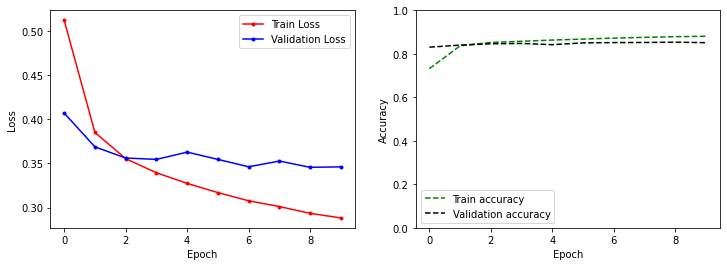

In [20]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(RMSprop_score.history['loss'], marker='.', c='red', label='Train Loss')
plt.plot(RMSprop_score.history['val_loss'], marker='.', c='blue', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(RMSprop_score.history['accuracy'], 'g--', label='Train accuracy')
plt.plot(RMSprop_score.history['val_accuracy'], 'k--', label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.show()

In [21]:
# 모델 평가
results = RMSprop_model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3548 - accuracy: 0.8471
[0.3548465371131897, 0.8470614552497864]


정확도를 85.10을 달성할 수 있었다.

#### Confusion Matrix

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


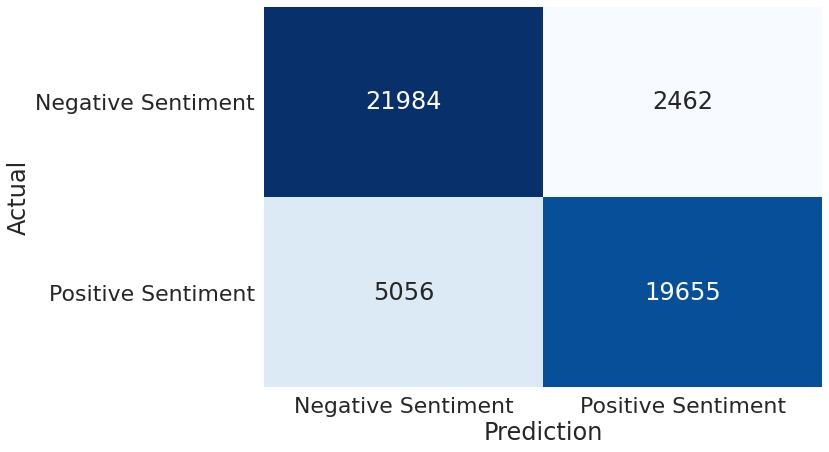

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.set(font_scale=2)
y_test_pred = RMSprop_model.predict_classes(X_test)
c_matrix = confusion_matrix(y_test, y_test_pred)
ax = sns.heatmap(c_matrix, annot=True, xticklabels=['Negative Sentiment', 'Positive Sentiment'],
                yticklabels=['Negative Sentiment', 'Positive Sentiment'], cbar=False, cmap='Blues', fmt='g')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
plt.show()

대부분의 예측은 맞았다. 틀린거는 negative 4568개, positive 2758개 였다.

In [23]:
false_negatives = [] # 예측은 부정. 실제로는 긍정적인 리뷰
false_positives = [] # 에측은 긍적. 실제로는 부정적인 리뷰

for i in range(len(y_test_pred)):
    if y_test_pred[i][0] != y_test[i]:
        if y_test[i] == 0: # FP: False Positive
            false_positives.append(i)
        else: # FN
            false_negatives.append(i)

In [24]:
print(false_negatives[20])
print(false_negatives[30])
print(false_negatives[100])

174
264
956


In [25]:
# 실제로는 긍정적인 리뷰이지만 예측은 부정으로 한 케이스
string_1 = get_decoded_sentence(X_test[100], index_to_word).replace("<PAD>", "").strip()
string_2 = get_decoded_sentence(X_test[500], index_to_word).replace("<PAD>", "").strip()
string_3 = get_decoded_sentence(X_test[3000], index_to_word).replace("<PAD>", "").strip()
print(string_1)
print(string_2)
print(string_3)

몇 안 되 고 졸작 만  .
진짜 없 네
영화 보고 시간 아깝 고 열받 영화 처음 다 . . 평점 5 점 딱 적당 하 다 . ..


In [26]:
print(false_positives[200])
print(false_positives[500])
print(false_positives[1500])

4225
10344
29989


In [27]:
# 실제로는 부정적인 리뷰이지만 예측은 긍정으로 한 케이스
string_1 = get_decoded_sentence(X_test[1000], index_to_word).replace("<PAD>", "").strip()
string_2 = get_decoded_sentence(X_test[15000], index_to_word).replace("<PAD>", "").strip()
string_3 = get_decoded_sentence(X_test[30000], index_to_word).replace("<PAD>", "").strip()
print(string_1)
print(string_2)
print(string_3)

하 누나 . .  누나 알 게 해 준 영화 . .
지 마 라 ! ! 꼭 공포 영화 자신 없 것 소리 만 지르 더라 ~ 포스터 더 무섭 다
영웅 바보 오가 놀라운 연기력


#### 딥러닝

In [28]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
# [[YOUR CODE]]
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                

In [29]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
188/188 [==============================] - 3s 10ms/step - loss: 0.6247 - accuracy: 0.6262 - val_loss: 0.3675 - val_accuracy: 0.8387
Epoch 2/10
188/188 [==============================] - 2s 8ms/step - loss: 0.3394 - accuracy: 0.8557 - val_loss: 0.3525 - val_accuracy: 0.8453
Epoch 3/10
188/188 [==============================] - 2s 9ms/step - loss: 0.2970 - accuracy: 0.8786 - val_loss: 0.3477 - val_accuracy: 0.8493
Epoch 4/10
188/188 [==============================] - 2s 9ms/step - loss: 0.2665 - accuracy: 0.8939 - val_loss: 0.3556 - val_accuracy: 0.8468
Epoch 5/10
188/188 [==============================] - 2s 9ms/step - loss: 0.2327 - accuracy: 0.9105 - val_loss: 0.3727 - val_accuracy: 0.8449
Epoch 6/10
188/188 [==============================] - 2s 9ms/step - loss: 0.2006 - accuracy: 0.9272 - val_loss: 0.3964 - val_accuracy: 0.8427
Epoch 7/10
188/188 [==============================] - 2s 9ms/step - loss: 0.1670 - accuracy: 0.9420 - val_loss: 0.4278 - val_accuracy: 0.8380
Epoch

1537/1537 - 4s - loss: 0.5841 - accuracy: 0.8223
[0.5840993523597717, 0.8222633600234985]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


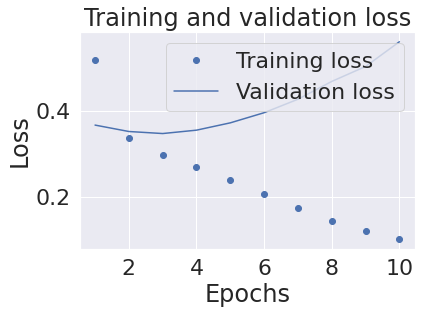

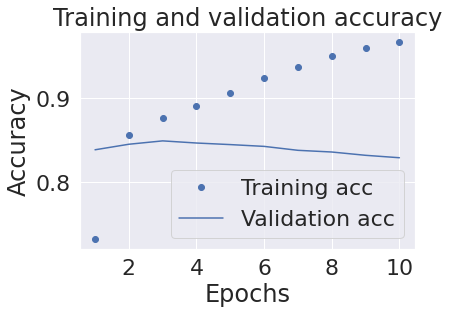

In [30]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)


history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들




acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)



# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



plt.clf()   # 그림을 초기화합니다
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Word2Vec

이전 스텝에서 라벨링 비용이 많이 드는 머신러닝 기반 감성분석의 비용을 절감하면서 정확도를 크게 향상시킬 수 있는 자연어처리 기법으로 단어의 특성을 저차원 벡터값으로 표현할 수 있는 워드 임베딩(word embedding) 기법이 있다는 언급을 한 바 있습니다.

우리는 이미 이전 스텝에서 워드 임베딩을 사용했습니다. 사용했던 model의 첫 번째 레이어는 바로 Embedding 레이어였습니다. 이 레이어는 우리가 가진 사전의 단어 개수 X 워드 벡터 사이즈만큼의 크기를 가진 학습 파라미터였습니다. 만약 우리의 감성분류 모델이 학습이 잘 되었다면, Embedding 레이어에 학습된 우리의 워드 벡터들도 의미 공간상에 유의미한 형태로 학습되었을 것입니다. 한번 확인해 봅시다.

## Embedding layer analysis

In [31]:
import os
import gensim
# genism = opensource library for the unsupervised learning and NLP
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


In [32]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/EXP_07_sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

 - 학습한 embedding parameter를 파일에 적어서 저장
 - for문을 이용하여, 특수 문자를 제외한 단어 갯수 만큼의 워드 벡터를 파일에 기록

In [33]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("사랑")

[('탄탄', 0.9257970452308655),
 ('잘생김', 0.8920600414276123),
 ('멋져', 0.891716480255127),
 ('가슴', 0.886619508266449),
 ('개꿀', 0.8799776434898376),
 ('해학', 0.8799475431442261),
 ('.^^', 0.8794417381286621),
 ('Ost', 0.8757149577140808),
 ('어우러지', 0.8738774061203003),
 ('들어온', 0.8697654008865356)]

 - 파일에 기록된 embedding parameter를 이용하여, word vector로 활용

 - 주어진 단어를 기준으로 유사한 단어, 유사도를 출력

 - '사랑'이라는 단어를 기준으로 유사도를 확인해본 결과, 연관성이 없다고 봐도 무방할 정도의 단어들이 출력

- 해당 단어들의 유사도는 0.85 이상으로, 꽤 높은 유사도를 보여주고 있음

- 실제 유사한 단어가 아님에도 높은 유사도를 보이는 것은, 주어진 단어가 한글이기 때문에 gensim이 잘 작동하지 않는다고 판단됨

### 한국어 Word2Vec 임베딩 활용하여 성능개선

한국어 Word2Vec은 다음 경로에서 구할 수 있습니다.
 - Pre-trained word vectors of 30+ languages (https://github.com/Kyubyong/wordvectors)

In [34]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [35]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [36]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([-0.09381163,  0.05544476,  0.03263109, -0.00901823,  0.00709184,
       -0.03479762, -0.04812231, -0.05766988,  0.03250196, -0.1059932 ,
        0.08567774, -0.05664757, -0.11091385, -0.0890365 , -0.08849512,
       -0.06719644], dtype=float32)

In [37]:
word_vectors.similar_by_word("재밌")


# 유사도를 분석!

[('재미있', 0.9605116844177246),
 ('한꺼번에', 0.9362316131591797),
 ('탄탄', 0.92751145362854),
 ('찾아왔', 0.9216235876083374),
 ('보냅니다', 0.9200071692466736),
 ('에게서', 0.9198455214500427),
 ('계신', 0.917788028717041),
 ('생생히', 0.9171590805053711),
 ('흠뻑', 0.9128606915473938),
 ('드릴게요', 0.9118597507476807)]

In [51]:
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/EXP_07_sentiment_classification/word2vec/ko.tar.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['영화']

vector     # 무려 300dim의 워드 벡터입니다.

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc8 in position 512: invalid continuation byte